In [1]:
import s3fs
import os
import os.path as op
import pandas as pd
import numpy as np

import afqinsight as afqi

/home/john/miniconda3/envs/afq/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
subjects_num_theory = [
    101208,
    102109,
    102614,
    102715,
    103010,
    103212,
    106824,
    108020,
    111211,
    113316,
    113417,
    114116,
    115724,
    116423,
    117021,
    117728,
    118831,
    119025,
    120010,
    120414,
    120818,
    122418,
    123723,
    125222,
    125424,
    126426,
    127226,
    127731,
    127832,
    130114,
    130518,
    130720,
    134627,
    135124,
    135629,
    136126,
    136328,
    136530,
    136631,
    137431,
    137532,
    138130,
    138332,
    139435,
    143224,
    143830,
    144933,
    145632,
    146735,
    146836
]
subjects_theory = [str(i) for i in subjects_num_theory] 

In [3]:
# download profiles
fs = s3fs.S3FileSystem()

if not op.exists('hcp_data'):
    os.mkdir('hcp_data')

subjects = []

for subject in subjects_theory:
    if not op.exists(f'hcp_data/sub-{subject}'):
        os.mkdir(f'hcp_data/sub-{subject}')
    try:
        fs.get(f'profile-hcp/afq/sub-{subject}/sess-01/sub-{subject}_dwi_profiles.csv', f'hcp_data/sub-{subject}/nodes.csv')
        subjects.append(subject)
    except FileNotFoundError:
        print(f'subject {subject} profiles not found')
subjects_num = [int(i) for i in subjects] 

subject 101208 profiles not found
subject 103212 profiles not found
subject 113417 profiles not found
subject 117728 profiles not found
subject 118831 profiles not found
subject 120818 profiles not found
subject 136328 profiles not found
subject 136530 profiles not found
subject 136631 profiles not found
subject 137431 profiles not found
subject 138332 profiles not found
subject 139435 profiles not found
subject 143224 profiles not found
subject 143830 profiles not found
subject 144933 profiles not found
subject 145632 profiles not found
subject 146735 profiles not found
subject 146836 profiles not found


In [51]:
# organize profiles
profile_all = pd.DataFrame(columns=['subjectID', 'tractID', 'nodeID', 'fa' , 'md'])
print(subjects)
for subject in subjects:
    print(subject)
    profile_curr = pd.read_csv(f'hcp_data/sub-{subject}/nodes.csv')
    for index, row in profile_curr.iterrows():
        profile_all = profile_all.append({'subjectID':subject,
                            'tractID':row['bundle'],
                            'nodeID':row['node'],
                            'fa':row['dki_fa'],
                            'md':row['dki_md']}, ignore_index=True)
profile_all.to_csv(f'hcp_data/nodes.csv', index=False)
     

['102109', '102614', '102715', '103010', '106824', '108020', '111211', '113316', '114116', '115724', '116423', '117021', '119025', '120010', '120414', '122418', '123723', '125222', '125424', '126426', '127226', '127731', '127832', '130114', '130518', '130720', '134627', '135124', '135629', '136126', '137532', '138130']
102109
102614
102715
103010
106824
108020
111211
113316
114116
115724
116423
117021
119025
120010
120414
122418
123723
125222
125424
126426
127226
127731
127832
130114
130518
130720
134627
135124
135629
136126
137532
138130


In [14]:
# organize subjects
subjects_pd = pd.read_csv('hcp_data/subjects.csv')
columns = subjects_pd.columns.values
if 'subjectID' not in columns:
    columns[0] = 'subjectID'
    subjects_pd.columns = columns
    subjects_pd.to_csv('hcp_data/subjects.csv', index=True)

In [110]:
from sklearn.decomposition import PCA
profile_all = pd.read_csv(f'hcp_data/nodes.csv')
fas = np.zeros((len(subjects), 1300))
for i, subject in enumerate(subjects_num):
    fa = profile_all[(profile_all['subjectID'] == subject) &
                (profile_all['tractID'] != 'ATR_R') &
                (profile_all['tractID'] != 'ATR_L') &
                (profile_all['tractID'] != 'HCC_R') &
                (profile_all['tractID'] != 'HCC_L') &
                (profile_all['tractID'] != 'ARC_R') &
                (profile_all['tractID'] != 'SLF_L') &
            (profile_all['tractID'] != 'CST_R')]['fa']
    print(subject)
    print(np.asarray(fa).shape)
    fas[i, :] = fa
bundle_labels = profile_all[(profile_all['subjectID'] == subject) &
        (profile_all['tractID'] != 'ATR_R') &
        (profile_all['tractID'] != 'ATR_L') &
        (profile_all['tractID'] != 'HCC_R') &
        (profile_all['tractID'] != 'HCC_L') &
        (profile_all['tractID'] != 'ARC_R') &
        (profile_all['tractID'] != 'SLF_L') &
        (profile_all['tractID'] != 'CST_R')]['tractID']

pca = PCA(n_components=5)
fas_transform = pca.fit_transform(fas)

102109
(1300,)
102614
(1300,)
102715
(1300,)
103010
(1300,)
106824
(1300,)
108020
(1300,)
111211
(1300,)
113316
(1300,)
114116
(1300,)
115724
(1300,)
116423
(1300,)
117021
(1300,)
119025
(1300,)
120010
(1300,)
120414
(1300,)
122418
(1300,)
123723
(1300,)
125222
(1300,)
125424
(1300,)
126426
(1300,)
127226
(1300,)
127731
(1300,)
127832
(1300,)
130114
(1300,)
130518
(1300,)
130720
(1300,)
134627
(1300,)
135124
(1300,)
135629
(1300,)
136126
(1300,)
137532
(1300,)
138130
(1300,)


In [89]:
fa_reduced = pca.inverse_transform(fas_transform)


In [90]:
print(fas)
print(fas.shape)
print(fa_reduced)
print(fa_reduced.shape)
print(fas_transform)
print(fas_transform.shape)

print(pca.explained_variance_ratio_)

[[0.18284211 0.23441487 0.31958902 ... 0.35952581 0.23306712 0.14770594]
 [0.20706503 0.23256594 0.27120757 ... 0.28119947 0.20124626 0.11800978]
 [0.21060012 0.23191947 0.25382226 ... 0.21790051 0.18357555 0.12953656]
 ...
 [0.20762477 0.22206423 0.25712868 ... 0.28877396 0.20056577 0.11733639]
 [0.21095713 0.25513588 0.30731522 ... 0.3175753  0.22648293 0.12556183]
 [0.18035073 0.21339364 0.24004688 ... 0.39093598 0.27745851 0.1363374 ]]
(32, 1300)
[[0.21534109 0.24356274 0.29129415 ... 0.32469094 0.23477321 0.14693996]
 [0.22224333 0.24991903 0.28572521 ... 0.31344708 0.23274229 0.14196231]
 [0.2101265  0.22628806 0.25907674 ... 0.28597385 0.21754592 0.13986939]
 ...
 [0.215806   0.2354797  0.26714222 ... 0.32457254 0.23446558 0.1478022 ]
 [0.20216456 0.24036934 0.29216984 ... 0.33375427 0.23756027 0.13469578]
 [0.20685806 0.24292485 0.29116267 ... 0.33336308 0.23828545 0.13765957]]
(32, 1300)
[[ 1.04341252  0.65701719  0.15975606  0.16602568 -0.48776177]
 [-0.98453475 -0.58212776  

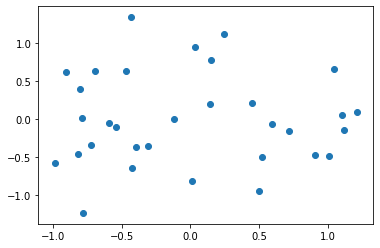

In [101]:
plt.scatter(fas_transform[:, 0], fas_transform[:, 1])

[[0.12156863 0.46666667 0.70588235]
 [0.12156863 0.46666667 0.70588235]
 [0.12156863 0.46666667 0.70588235]
 ...
 [0.89019608 0.46666667 0.76078431]
 [0.89019608 0.46666667 0.76078431]
 [0.89019608 0.46666667 0.76078431]]


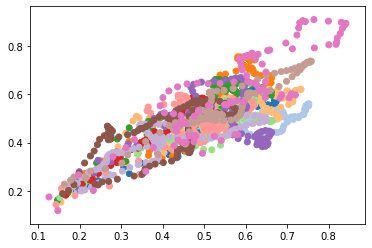

In [97]:
import matplotlib.pyplot as plt
from palettable.tableau import Tableau_20

tableau_20_rgb = np.array(Tableau_20.colors) / 255
print(np.repeat(tableau_20_rgb[:13], 100, axis=0))
plt.scatter(fas[0, :], fas[1, :], c=np.repeat(tableau_20_rgb[:13], 100, axis=0))

In [102]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]

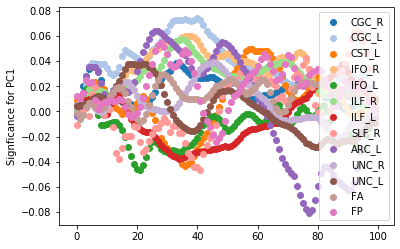

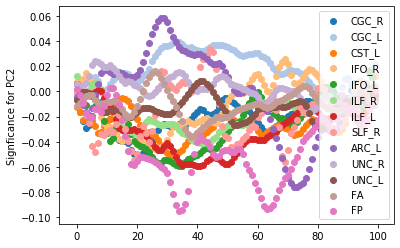

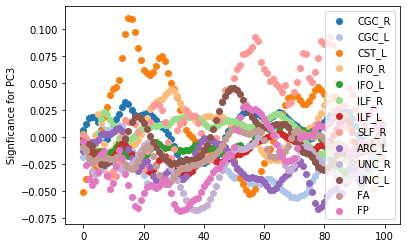

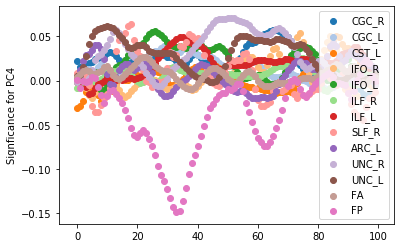

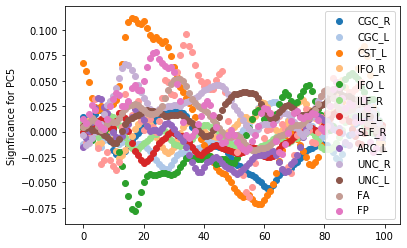

In [123]:
x = np.tile(np.arange(100), (13, 1))
c = np.repeat(tableau_20_rgb[:13], 100, axis=0)
for i in range(5):
    for j in range(13):
        plt.scatter(np.arange(100), pca.components_[i, j*100:(j+1)*100], c=[tableau_20_rgb[j]], label=bundle_labels.to_numpy()[j*100])
    plt.legend()
    plt.ylabel(f'Signficance for PC{i+1}')
    plt.show()
    # other manifold learning techniques, may be better than PCA, like local linear embedding
    # Eventually put this in an unsupervised submodule / PR
    # try to reconstruct tract profiles using only N PCs, use train test, ultimately it may reconstruct differently in different individuals

In [121]:
print(bundle_labels.to_numpy()[100])

CGC_L


In [4]:
afq_data = afqi.load_afq_data('hcp_data', "ReadEng_AgeAdj") # subjects_pd.columns

In [5]:
# print(afq_data.y)
x, y, groups, cols = afq_data.x, afq_data.y.loc[subjects_num].to_numpy(), afq_data.groups, afq_data.columns
# print(x.shape)
# print(y)
# print(x)

In [ ]:
print(x)

In [124]:
hp_res_auc = afqi.sgl_estimator_cv(
    x, y, groups,
    loss_type='square',
    verbose=1, random_state=42
)

ValueError: Found input variables with inconsistent numbers of samples: [13, 32]

In [36]:
for i in range(10, 500, 10):
    hp_cv_res_auc = afqi.fit_hyperparams_cv(
        x, y, groups, max_evals_per_cv=i,
        score='rmse',
        loss_type='square',
        trials_pickle_dir='./cv_trials_cv4_rs42_rmse',
        verbose=2, random_state=42, clf_threshold=0.5,
        n_splits=4
    )

100%|██████████| 10/10 [00:50<00:00, 12.44s/trial, best loss: 14.45845601964956]


100%|██████████| 20/20 [01:39<00:00,  9.47s/trial, best loss: 14.347462960005736]


100%|██████████| 30/30 [01:47<00:00, 11.10s/trial, best loss: 14.343150389102155]


100%|██████████| 40/40 [01:35<00:00, 10.22s/trial, best loss: 14.343150389102155]


100%|██████████| 50/50 [01:39<00:00,  9.91s/trial, best loss: 14.343150389102155]


 98%|█████████▊| 59/60 [01:38<00:11, 11.66s/trial, best loss: 14.641772018424374]


KeyboardInterrupt: 

In [29]:
hp_res_auc

{'alpha1': 0.0,
 'alpha2': 0.0,
 'eta': 1.0,
 'transform_type': None,
 'beta_hat': [array([0.026294, 0.026294, 0.026294, ..., 0.026294, 0.026294, 0.026294]),
  array([0.02640709, 0.02640709, 0.02640709, ..., 0.02640709, 0.02640709,
         0.02640709]),
  array([0.02666342, 0.02666342, 0.02666342, ..., 0.02666342, 0.02666342,
         0.02666342])],
 'test': [{'x': array([[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]]),
   'y': array([106.2624 , 113.3487 , 109.4368 ,  86.01183, 122.8106 , 122.0148 ,
          125.9454 , 102.2126 , 112.8914 ,  98.55106,  78.74939]),
   'rmse': 14.424529116994458,
   'r2': -0.017845676581935255,
   'medae': 8.146401904374343},
  {'x': array([[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],


In [31]:
beta_hat_ls = [cv["beta_hat"] for cv in hp_cv_res_auc]

In [15]:
#limit subject number
afqi.plot.plot_pca_space(afq_data.x, afq_data.y.loc[subjects_num], np.mean(hp_res_auc['beta_hat'], axis=0), 'regression', 'ReadEng_AgeAdj')

TypeError: unsupported operand type(s) for *: 'float' and 'collections.OrderedDict'

In [18]:
import importlib
importlib.reload(afqi)

<module 'afqinsight' from '/home/john/AFQ-Insight/afqinsight/__init__.py'>

In [33]:
def tract_map(name):
    if name == 'Right Corticospinal':
        return 'CST_R'
    elif name == 'Left Corticospinal':
        return 'CST_L'
    elif name == 'Right Uncinate':
        return 'UNC_R'
    elif name == 'Left Uncinate':
        return 'UNC_L'
    elif name == 'Left IFOF':
        return 'IFO_L'
    elif name == 'Right IFOF':
        return 'IFO_R'
    elif name == 'Right Arcuate':
        return 'ARC_R'
    elif name == 'Left Arcuate':
        return 'ARC_L'
    elif name == 'Right Thalamic Radiation':
        return 'ATR_R'
    elif name == 'Left Thalamic Radiation':
        return 'ATR_L'
    elif name == 'Right Cingulum Cingulate':
        return 'CGC_R'
    elif name == 'Left Cingulum Cingulate':
        return 'CGC_L'
    elif name == 'Right Cingulum Hippocampus':
        return 'HCC_R'
    elif name == 'Left Cingulum Hippocampus':
        return 'HCC_L'
    elif name == 'Callosum Forceps Major':
        return 'FP'
    elif name == 'Callosum Forceps Minor':
        return 'FA'
    elif name == 'Right ILF':
        return 'ILF_R'
    elif name == 'Left ILF':
        return 'ILF_L'
    elif name == 'Right SLF':
        return 'SLF_R'
    elif name == 'Left SLF':
        return 'SLF_L'
    else:
        return name

tract_names=[
    'CST_R',
    'CST_L',
    'UNC_R',
    'UNC_L',
    'IFO_L',
    'IFO_R',
    'ARC_R',
    'ARC_L',
    'ATR_R',
    'ATR_L',
    'CGC_R',
    'CGC_L',
    'HCC_R',
    'HCC_L',
    'FP',
    'FA',
    'ILF_R',
    'ILF_L',
    'SLF_R',
    'SLF_L'
]
    
beta_unfolded = afqi.transform.unfold_beta_hat_by_metrics(betas, cols, tract_names=tract_names)

In [34]:
afqi.plot.plot_unfolded_beta(beta_unfolded, tract_names=tract_names)

In [32]:
betas = np.asarray(beta_hat_ls)
print(betas.shape)
betas=np.mean(betas[:, :-1], axis=0)
print(betas.shape)

(4, 4001)
(4000,)


No streamlines found for subject 125424 for bundle CST_R


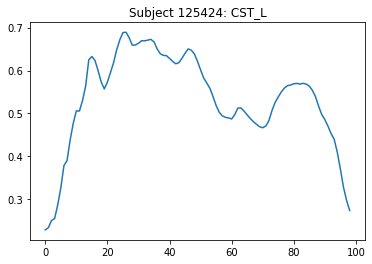

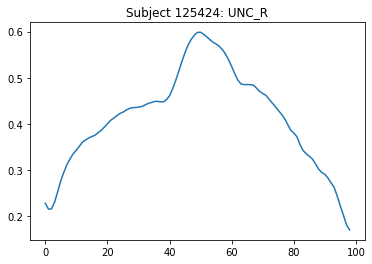

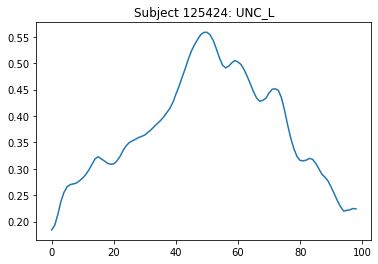

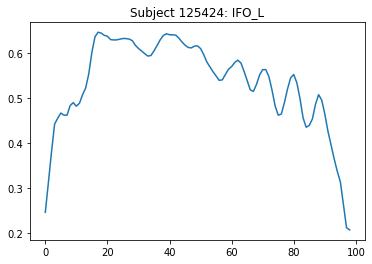

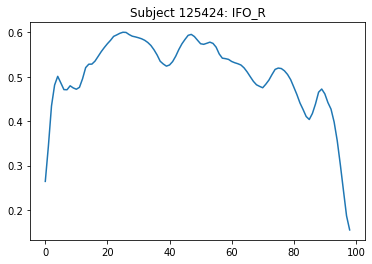

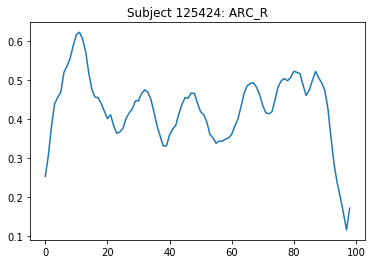

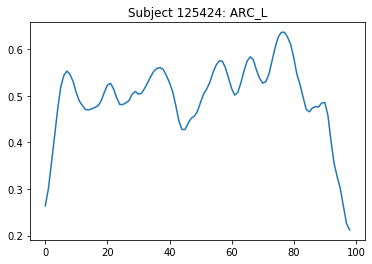

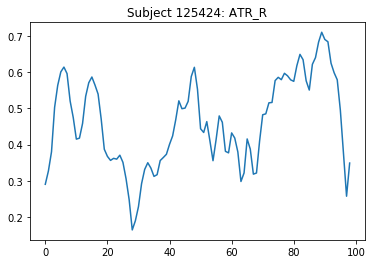

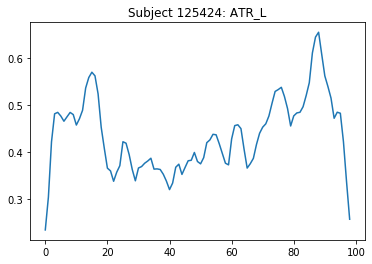

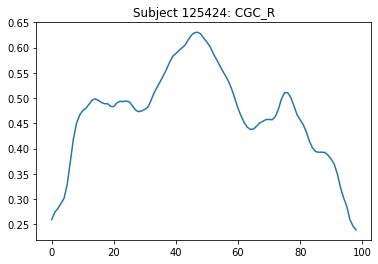

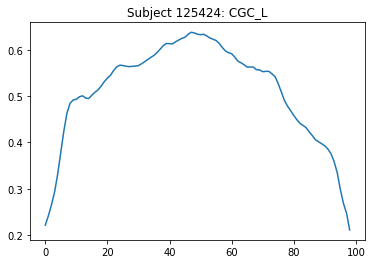

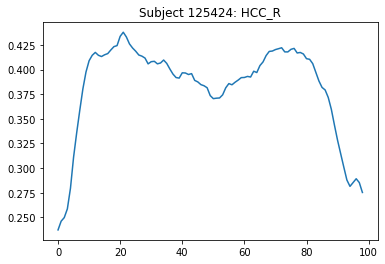

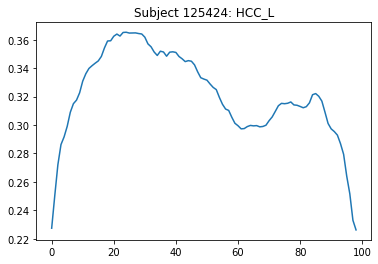

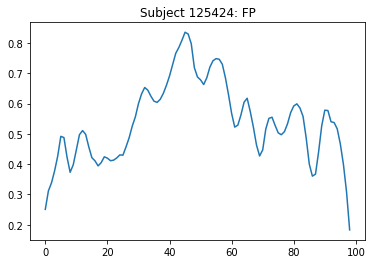

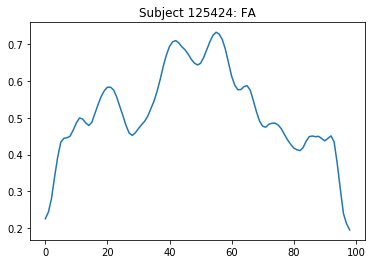

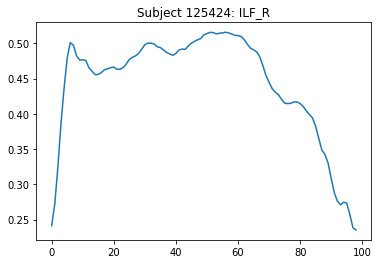

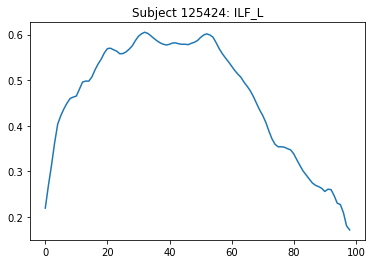

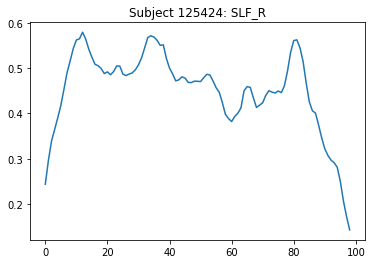

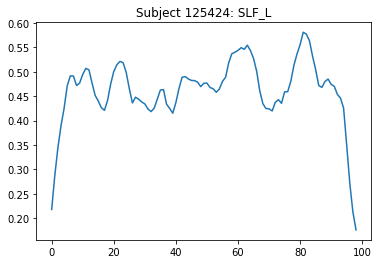

      125424
CST_R    NaN
CST_L     99
UNC_R     99
UNC_L     99
IFO_L     99
IFO_R     99
ARC_R     99
ARC_L     99
ATR_R     99
ATR_L     99
CGC_R     99
CGC_L     99
HCC_R     99
HCC_L     99
FP        99
FA        99
ILF_R     99
ILF_L     99
SLF_R     99
SLF_L     99


In [53]:
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
bundles = ['CST_R', 'CST_L', 'UNC_R', 'UNC_L',
           'IFO_L', 'IFO_R', 'ARC_R', 'ARC_L',
           'ATR_R', 'ATR_L', 'CGC_R', 'CGC_L',
           'HCC_R', 'HCC_L', 'FP', 'FA',
           'ILF_R', 'ILF_L', 'SLF_R', 'SLF_L']
average_fas = pd.DataFrame(index=bundles, columns=[125424])#subjects_num)
profiles_afq = pd.read_csv(f'hcp_data/nodes.csv')
for subject in [125424]:
    if subject == 102109:
        continue
    for bundle in bundles:
        afq_test = profiles_afq[(profiles_afq['tractID'] == bundle) & (profiles_afq['subjectID'] == subject)]['fa']
        afq_test = afq_test.to_numpy()[1:]
        if (len(afq_test) > 0):
            plt.plot(afq_test)
            plt.title('Subject ' + str(subject) + ': ' + bundle)
            plt.show()
            average_fas.at[bundle, subject] = len(afq_test)
        else:
            print('No streamlines found for subject ' + str(subject) + ' for bundle ' + bundle)
print(average_fas)